#RidgeClassifier
* Ridge classifier cast the problem as least square classification and finds the optimal weight using some matrix decomposition technique such as SVD.
* To train RidgeClassifier, the labels should be {-1, +1}
* The classifier by default implements L2 regularization. 

However we first implement it without regularization by setting alpha=0

In [ ]:
import numpy as np
import os
import io
import warnings

from sklearn.datasets import fetch_openml
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import SGDClassifier, RidgeClassifier, LogisticRegressionCV, LogisticRegression
from sklearn.metrics import hinge_loss
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, precision_recall_curve
from sklearn.metrics import precision_score, recall_score, classification_report
from sklearn.metrics import make_scorer, roc_curve, roc_auc_score, log_loss
from sklearn.model_selection import cross_validate, cross_val_predict, GridSearchCV, RandomizedSearchCV
from pprint import pprint

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

from scipy.stats import loguniform
np.random.seed(42)

#global settings
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
mpl.rc('figure', figsize=(8,6))

In [ ]:
#Ignore all warnings
def warn(*args, **kwargs):
  pass
warnings.warn = warn

In [ ]:
X_pd, y_pd = fetch_openml('mnist_784', version=1, return_X_y=True)
X = X_pd.to_numpy()
y = y_pd.to_numpy()

X_train, X_test, y_train, y_test  = X[:60000], X[60000:], y[:60000], y[60000:]

In [ ]:
y_train_0 = -1 * np.ones((len(y_train)))
y_test_0 = -1 * np.ones((len(y_test)))

#find the indices of digit 0
indx_0 = np.where(y_train == '0') # oroginal labels are str, not int
#use these indices to modify y_train_0 and y_test_0
y_train_0[indx_0] = 1 

indx_0 = np.where(y_test == '0')
y_test_0[indx_0] = 1

In [ ]:
estimator = RidgeClassifier(normalize=False, alpha=0)
pipe_ridge = make_pipeline(MinMaxScaler(), estimator)
pipe_ridge.fit(X_train, y_train_0)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('ridgeclassifier', RidgeClassifier(alpha=0, normalize=False))])

##Performance

In [ ]:
y_hat_test_0 = pipe_ridge.predict(X_test)
print(classification_report(y_test_0, y_hat_test_0))

              precision    recall  f1-score   support

        -1.0       0.99      0.99      0.99      9020
         1.0       0.95      0.88      0.91       980

    accuracy                           0.98     10000
   macro avg       0.97      0.94      0.95     10000
weighted avg       0.98      0.98      0.98     10000



##Cross Validation

In [ ]:
cv_bin_ridge_clf = cross_validate(pipe_ridge,
                                  X_train, y_train_0, cv=5,
                                  scoring=['precision', 'recall', 'f1'],
                                  return_train_score=True,
                                  return_estimator=True
                                  )
pprint(cv_bin_ridge_clf)

{'estimator': [Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('ridgeclassifier', RidgeClassifier(alpha=0, normalize=False))]),
               Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('ridgeclassifier', RidgeClassifier(alpha=0, normalize=False))]),
               Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('ridgeclassifier', RidgeClassifier(alpha=0, normalize=False))]),
               Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('ridgeclassifier', RidgeClassifier(alpha=0, normalize=False))]),
               Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('ridgeclassifier', RidgeClassifier(alpha=0, normalize=False))])],
 'fit_time': array([14.04396272, 19.25759172, 13.33110118, 13.86112499, 10.63280654]),
 'score_time': array([0.09708738, 0.17692542, 0.097718  , 0.14104843, 0.10044932]),
 'test_f1': array([0.9123734 , 0.90260026, 0.91596265, 0.90429338, 0.90982143]),
 'test_preci

In [ ]:
best_estimator_id = np.argmax(cv_bin_ridge_clf['train_f1']) 
best_estimator_id

3

In [ ]:
best_estimator = cv_bin_ridge_clf['estimator'][best_estimator_id]
print(best_estimator)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('ridgeclassifier', RidgeClassifier(alpha=0, normalize=False))])


In [ ]:
y_hat_test_0 = best_estimator.predict(X_test)
print(classification_report(y_test_0, y_hat_test_0))

              precision    recall  f1-score   support

        -1.0       0.99      0.99      0.99      9020
         1.0       0.95      0.88      0.91       980

    accuracy                           0.98     10000
   macro avg       0.97      0.94      0.95     10000
weighted avg       0.98      0.98      0.98     10000



#Multiclass Classifier (OneVsAll)
##Multiclass Logit with SGD

In [ ]:
estimator = SGDClassifier(loss='log',
                            penalty='l2',
                            max_iter=1,
                            warm_start=True,
                            eta0=0.01,
                            alpha=0,
                            learning_rate='constant',
                            random_state=1729
                            )
pipe_sgd_ovr = make_pipeline(MinMaxScaler(), estimator)
loss = []
iterations=100
for i in range(iterations):
  pipe_sgd_ovr.fit(X_train, y_train)
  y_pred = pipe_sgd_ovr.predict_proba(X_train)
  loss.append(log_loss(y_train, y_pred))

it almost took 5 minutes for training

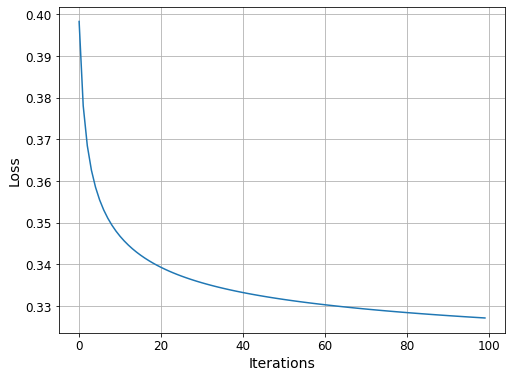

In [ ]:
plt.figure()
plt.plot(np.arange(iterations), loss)
plt.grid(True)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()

what actually happened behind the scene is the library automatically created 10 bunary classifiers and trained them. During the inference time, the input will be passed thru all 10 classifiers and the highest score among the outputs will be considered as the predicted class. 

In [ ]:
pipe_sgd_ovr[1]

SGDClassifier(alpha=0, eta0=0.01, learning_rate='constant', loss='log',
              max_iter=1, random_state=1729, warm_start=True)

In [ ]:
pipe_sgd_ovr[1].coef_.shape

(10, 784)

It is a matrix of size 10 x 784. A row represents the weights of a single binary classifier.

In [ ]:
y_hat = pipe_sgd_ovr.predict(X_test)
y_hat[:5]

array(['7', '2', '1', '0', '4'], dtype='<U1')

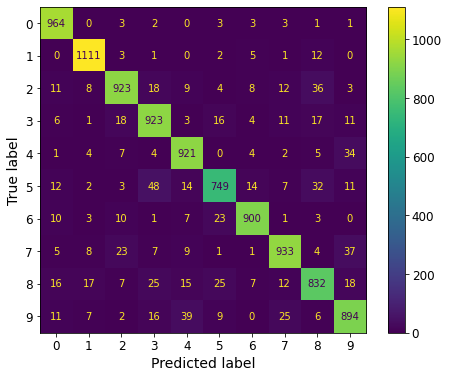

In [ ]:
cm_disply = ConfusionMatrixDisplay.from_predictions(y_test, y_hat, values_format='.5g')
plt.show()

In [ ]:
print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

           0       0.93      0.98      0.96       980
           1       0.96      0.98      0.97      1135
           2       0.92      0.89      0.91      1032
           3       0.88      0.91      0.90      1010
           4       0.91      0.94      0.92       982
           5       0.90      0.84      0.87       892
           6       0.95      0.94      0.95       958
           7       0.93      0.91      0.92      1028
           8       0.88      0.85      0.87       974
           9       0.89      0.89      0.89      1009

    accuracy                           0.92     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.92      0.91     10000



#Multiclass LogisticRegression using solvers

In [ ]:
pipe_logit_ovr = make_pipeline(MinMaxScaler(), LogisticRegression(random_state=1729, solver='lbfgs', C=np.infty))
pipe_logit_ovr.fit(X_train, y_train)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('logisticregression',
                 LogisticRegression(C=inf, random_state=1729))])

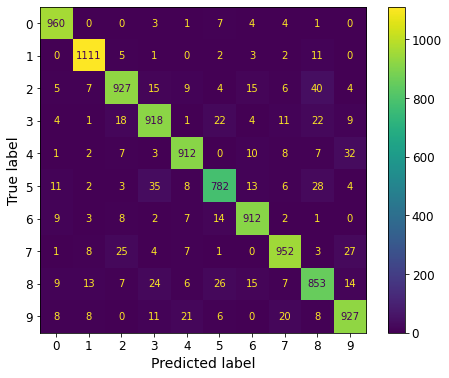

In [ ]:
y_hat = pipe_logit_ovr.predict(X_test)
cm_display = ConfusionMatrixDisplay.from_predictions(y_test, y_hat, values_format='.5g')
plt.show()

In [ ]:
print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

           0       0.95      0.98      0.97       980
           1       0.96      0.98      0.97      1135
           2       0.93      0.90      0.91      1032
           3       0.90      0.91      0.91      1010
           4       0.94      0.93      0.93       982
           5       0.91      0.88      0.89       892
           6       0.93      0.95      0.94       958
           7       0.94      0.93      0.93      1028
           8       0.88      0.88      0.88       974
           9       0.91      0.92      0.92      1009

    accuracy                           0.93     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.93      0.93      0.93     10000



In [ ]:
w = pipe_logit_ovr.coef_  